In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 5  # number of inputs
d = 5  # input dimension
M = 3  # bound for distribution
L = 2  # number of layers
batch_size = 128
validation_size = 8
epochs = 10000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# distribution for x (uniform in [-M, M]) and w
def generate_data(batch_size, d, n, M, device):
    # x = (torch.rand(batch_size, n+1, d, device=device) - 0.5) * 2 * M  # uniform distribution. of shape (batch_size, n+1, d)
    x = torch.randn(batch_size, n+1, d, device=device)*M # normal distribution N(0, M^2). of shape (batch_size, n+1, d)
    w_star = torch.randn(batch_size, d, device=device)  # normal distribution N(0, 1) of shape (batch_size, d)
    y = (x * w_star.unsqueeze(1)).sum(dim=2) # taking inner product of x_i and w for each batch. of shape(batch_size, n+1)
    return x, y, w_star # y[:,n] are the true y_{n+1} values

class LinearTransformer(nn.Module):
    def __init__(self, d, n, L, device):
        super(LinearTransformer, self).__init__()
        self.L = L
        self.n = n
        self.device = device

        # random
        self.P_list = nn.ParameterList([nn.Parameter(torch.randn(d+1, d+1, device=device) * 0.1) for _ in range(L)])
        self.Q_list = nn.ParameterList([nn.Parameter(torch.randn(d+1, d+1, device=device) * 0.1) for _ in range(L)])

        # small number
        #self.P_list = nn.ParameterList([nn.Parameter(torch.ones(d+1, d+1, device=device) * 0.001) for _ in range(L)])
        #self.Q_list = nn.ParameterList([nn.Parameter(torch.ones(d+1, d+1, device=device) * 0.001) for _ in range(L)])

        # zero doesn't work
        # self.P_list = nn.ParameterList([nn.Parameter(torch.zeros(d+1, d+1, device=device)) for _ in range(L)])
        # self.Q_list = nn.ParameterList([nn.Parameter(torch.zeros(d+1, d+1, device=device)) for _ in range(L)])

        self.M = torch.block_diag(torch.eye(n, device=device), torch.zeros(1,1, device=device))

    def forward(self, Z):
        # Z is given as shape (batch_size, d+!, n+1)
        batch_size = Z.shape[0]
        for l in range(self.L):
            P = self.P_list[l]
            Q = self.Q_list[l]
            # batched version of Z_tilde = Z.T @ Q @ Z
            Z_tilde = torch.bmm(Z.transpose(1, 2), Q.unsqueeze(0).expand(batch_size, -1, -1))
            Z_tilde = torch.bmm(Z_tilde, Z)

            # batched version of Attn_PQ = P @ Z @ self.M @ Z_tilde
            Attn_PQ = torch.bmm(P.unsqueeze(0).expand(batch_size, -1, -1), Z)
            Attn_PQ = torch.bmm(Attn_PQ, self.M.unsqueeze(0).expand(batch_size, -1, -1))
            Attn_PQ = torch.bmm(Attn_PQ, Z_tilde)
            Z = Z + Attn_PQ / self.n
        return Z

In [ ]:
def loss_function(ZL, y_true):
    y_hat = -ZL[:,-1,-1] # shape (batch_size,)
    return torch.mean((y_hat - y_true)**2)

In [ ]:
# Generate both training and validation data
train_x, train_y, _ = generate_data(batch_size, d, n, M, device)
val_x, val_y, _ = generate_data(validation_size, d, n, M, device)

# Initialize the model, optimizer, and loss function
model = LinearTransformer(d=d, n=n, L=L, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    # Forward pass and loss calculation
    Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
    Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
    ZL = model(Z0)  # Apply the linear transformer
    train_loss = loss_function(ZL, train_y[:,-1])

    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_Z0 = torch.cat((torch.transpose(val_x, 1, 2), val_y.unsqueeze(1)), dim=1)
        val_Z0[:,-1,-1] = 0  # initialize y_{n+1} as 0 for validation
        val_ZL = model(val_Z0)
        val_loss = loss_function(val_ZL, val_y[:, -1])

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

Epoch 1/10000, Training Loss: 2274.20849609375, Validation Loss: 300.6625671386719
Epoch 501/10000, Training Loss: 27.542476654052734, Validation Loss: 38.074440002441406
Epoch 1001/10000, Training Loss: 16.904830932617188, Validation Loss: 53.005889892578125
Epoch 1501/10000, Training Loss: 12.582306861877441, Validation Loss: 50.75198745727539
Epoch 2001/10000, Training Loss: 10.284507751464844, Validation Loss: 46.98761749267578
Epoch 2501/10000, Training Loss: 8.57266616821289, Validation Loss: 91.08258056640625
Epoch 3001/10000, Training Loss: 7.1929192543029785, Validation Loss: 190.68658447265625
Epoch 3501/10000, Training Loss: 6.273012638092041, Validation Loss: 305.0662841796875
Epoch 4001/10000, Training Loss: 4.649333477020264, Validation Loss: 416.7281799316406
Epoch 4501/10000, Training Loss: 3.451326847076416, Validation Loss: 471.950927734375
Epoch 5001/10000, Training Loss: 2.9418368339538574, Validation Loss: 478.0611572265625
Epoch 5501/10000, Training Loss: 2.479882

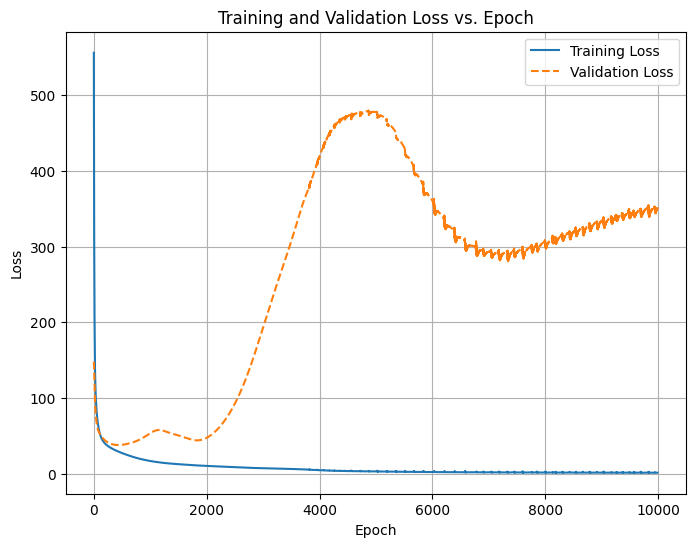

In [ ]:

z1 = zip(train_losses, val_losses)
z2 = list(filter(lambda x: x[0]<600, z1))
train_graph = [x[0] for x in z2]
val_graph = [x[1] for x in z2]
epoch_num = len(train_graph)

# Plot the loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epoch_num+1), train_graph, label='Training Loss')
plt.plot(range(1, epoch_num+1), val_graph, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# set_weights(model, original_weights)

[[23.83533859 23.38577461 22.90818024]
 [23.70453262 23.25612259 22.7810154 ]
 [23.57157516 23.12362289 22.6501236 ]]


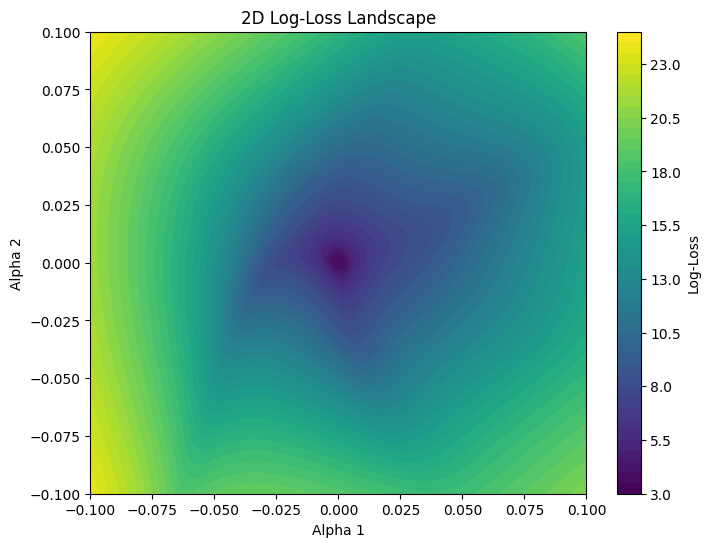

In [ ]:
def get_loss(model, x, y, device):
    model.eval()
    with torch.no_grad():
        Z0 = torch.cat((torch.transpose(x, 1, 2), y.unsqueeze(1)), dim=1)  # Prepare Z0
        Z0[:, d, n] = 0  # Initialize y_{n+1} as 0
        ZL = model(Z0)  # Apply the linear transformer
        loss = loss_function(ZL, y[:, n])
    return loss.item()

# Save the original model parameters
def get_current_weights(model):
    return [param.clone() for param in model.parameters()]

# Interpolate between the original weights and the random directions
def interpolate_weights(original_weights, direction1, direction2, alpha1, alpha2):
    new_params = []
    for param, delta1, delta2 in zip(original_weights, direction1, direction2):
        new_param = param + alpha1 * delta1 + alpha2 * delta2
        new_params.append(new_param)
    return new_params

# Set model parameters with the interpolated weights
def set_weights(model, new_params):
    with torch.no_grad():
        for param, new_param in zip(model.parameters(), new_params):
            param.copy_(new_param)

# Generate two random directions in the parameter space
direction1 = [torch.randn_like(p) for p in model.parameters()]
direction2 = [torch.randn_like(p) for p in model.parameters()]

# Save the original weights (after training) to start interpolation from them
original_weights = get_current_weights(model)

# Set up grid for the landscape
alpha_range = np.linspace(-0.1, 0.1, 50)  # Adjust range and resolution
loss_landscape = np.zeros((50, 50))

# Compute the loss for each combination of alpha1 and alpha2
for i, alpha1 in enumerate(alpha_range):
    for j, alpha2 in enumerate(alpha_range):
        # Interpolate from the original weights, not from modified ones
        new_params = interpolate_weights(original_weights, direction1, direction2, alpha1, alpha2)
        set_weights(model, new_params)  # Set the interpolated weights
        loss_landscape[i, j] = torch.log(torch.FloatTensor([get_loss(model, train_x, train_y, device)]))  # Compute the loss with these weights

print(loss_landscape[:3,:3])

# Plot the 2D loss landscape
plt.figure(figsize=(8, 6))
plt.contourf(alpha_range, alpha_range, loss_landscape, levels=50, cmap='viridis')
plt.colorbar(label='Log-Loss')
plt.xlabel('Alpha 1')
plt.ylabel('Alpha 2')
plt.title('2D Log-Loss Landscape')
plt.show()